# Angle Recovery with Perfect Distances

In this phase we will try to do angle recovery assuming we know the prefect distances.

Add equation

## Read Data

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

In [1]:
import os
import h5py
import numpy as np

import sys
sys.path.append("../../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space
from cryoem.angle_recovery import geodesic_distance, update_angles, distance_difference, find_best_rotation

In [2]:
PROTEIN="5a1a"
ROOT_DIR = "../../.."
NUM_PROJECTIONS = 5000

In [3]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [4]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

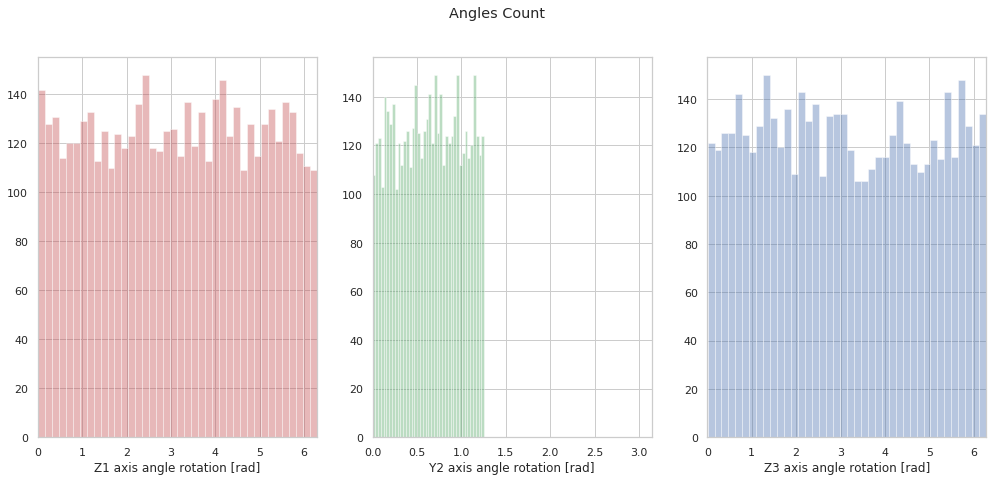

In [5]:
plot_angles_count(angles_true)

### Predicted Angles

In [6]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

In [7]:
from tensorflow.python.framework import ops

def mod_angles(e, angle_shift, angle_coverage):
    values = ops.convert_to_tensor(e.values if isinstance(e, ops.IndexedSlices) else e, name="e")

    v1 = tf.math.mod(values[0], 2*np.pi)
    v2 = tf.math.mod(values[1], np.pi)
    v3 = tf.math.mod(values[2], 2*np.pi)
    
    v1 = tf.clip_by_value(v1, angle_shift[0]*np.pi, angle_shift[0]*np.pi+angle_coverage[0]*np.pi)
    v2 = tf.clip_by_value(v2, angle_shift[1]*np.pi, angle_shift[1]*np.pi+angle_coverage[1]*np.pi)
    v3 = tf.clip_by_value(v3, angle_shift[2]*np.pi, angle_shift[2]*np.pi+angle_coverage[2]*np.pi)


    return tf.stack((v1, v2, v3), axis=-1)

In [8]:
low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

angles_predicted = [tf.Variable(e, constraint=lambda x: mod_angles(x, angle_shift, angle_coverage)) for e in euler]
#angles_predicted = [tf.Variable(e) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

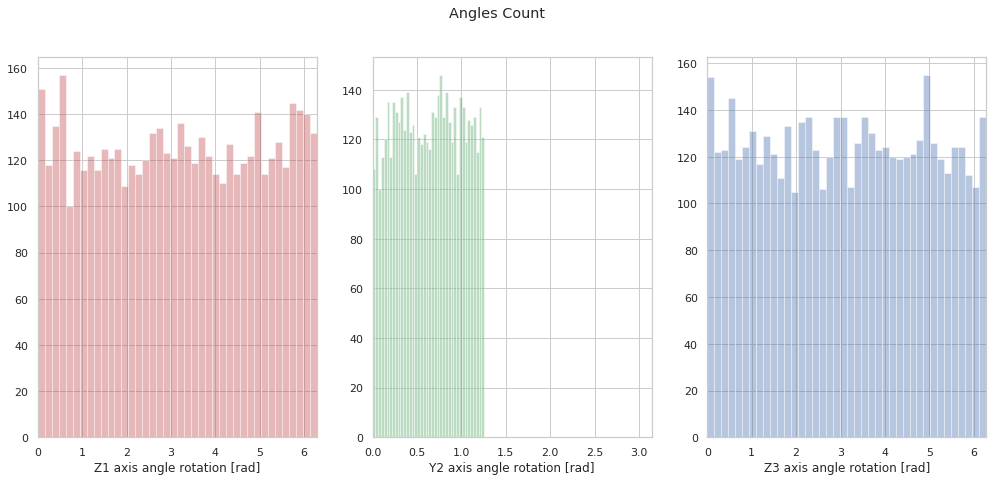

In [9]:
plot_angles_count(angles_predicted)

In [10]:
plot_euclidean_space(angles_predicted)

In [11]:
plot_euclidean_space(angles_true)

---

# Angle Recovery - Perfect Distance

## dP/dQ plot

In [12]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [13]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [14]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

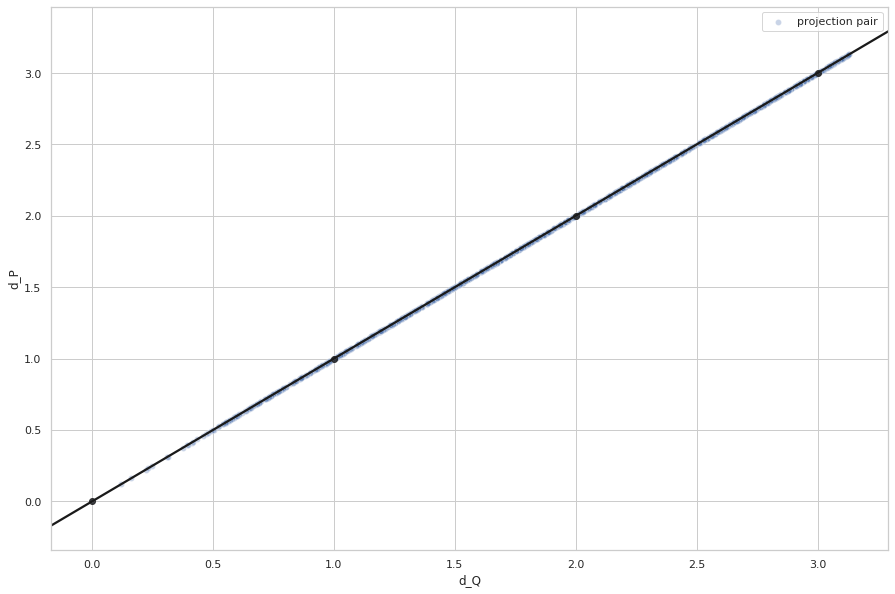

In [15]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

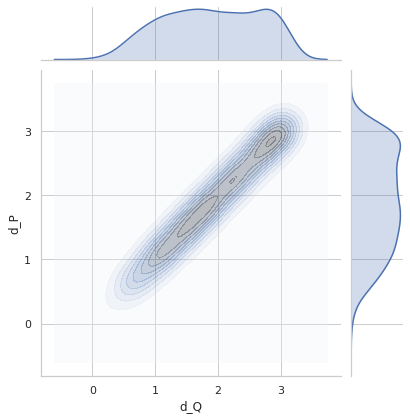

In [16]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [17]:
from cryoem.angle_recovery import train_angle_recovery

In [ ]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

step 15000/150000 (13076s): loss = 8.81e-02
step 30000/150000 (27084s): loss = 1.05e-01
step 45000/150000 (41164s): loss = 9.06e-02
step 60000/150000 (55318s): loss = 7.34e-02
step 75000/150000 (68870s): loss = 5.44e-02
step 90000/150000 (81926s): loss = 4.34e-02
step 105000/150000 (95349s): loss = 2.24e-02
step 120000/150000 (109027s): loss = 2.05e-02


In [ ]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("predicted_angles_modulo.npy")

In [ ]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [1]:
filename = f"figures/{PROTEIN}_before_alignment"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

### Alignment

#### Flip 3rd angle

### Angle Alignment

In [10]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

#### Quaternion Alignment

In [2]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

In [3]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [4]:
flips, a_R, loss

In [14]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [5]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

In [6]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [7]:
filename = f"figures/{PROTEIN}_after_alignment"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

#### Geodesic Alignment

In [8]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

In [9]:
flips, (a_R, loss) = training_angle_alignment_GD_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [10]:
flips, a_R, loss

In [21]:
angles_predicted_new = updateGD_alignment(flips, ap, a_R)

In [11]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

In [12]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))